# 0-Libraries

In [14]:
import numpy as np
import matplotlib.pyplot as plt
import itertools
import pandas as pd
import sklearn
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix,classification_report,ConfusionMatrixDisplay, balanced_accuracy_score
#from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import Normalizer, StandardScaler, MinMaxScaler, MaxAbsScaler, RobustScaler, QuantileTransformer, PowerTransformer
import tensorflow as tf
from tensorflow import keras
from keras import regularizers
from keras.optimizers import Adam
#from keras.backend import expand_dims
from keras.callbacks import ReduceLROnPlateau, EarlyStopping
from keras.models import Sequential
from keras.constraints import MaxNorm
from keras.layers import Activation, Dense, Conv1D, Flatten, MaxPooling1D, Dropout, BatchNormalization, SpatialDropout1D,Input,Lambda





In [15]:
METRICS = [
      keras.metrics.TruePositives(name='tp'),
      keras.metrics.FalsePositives(name='fp'),
      keras.metrics.TrueNegatives(name='tn'),
      keras.metrics.FalseNegatives(name='fn'),
      keras.metrics.BinaryAccuracy(name='accuracy'),
      keras.metrics.Precision(name='precision'),
      keras.metrics.Recall(name='recall'),
      keras.metrics.AUC(name='auc'),
      keras.metrics.AUC(name='prc', curve='PR'), # precision-recall curve
]

# 1- Load Data

In [16]:
s_aureus = pd.read_csv('e_coli_driams_b_2000_20000Da_v2 (1).csv')
s_aureus.head()

,2000,2003,2006,2009,2012,2015,2018,2021,2024,2027,...,19988,19991,19994,19997,code,species,Ciprofloxacin,Ceftriaxone,Cefepime,Piperacillin-Tazobactam
0,1067.142857,1251.714286,1310.571429,1021.142857,1315.625000,974.000000,936.857143,853.571429,936.142857,1044.285714,...,21.5,6.500000,4.666667,17.585859,dcd5aa31-b254-4961-b69f-ccc8c0572b27,Escherichia coli,0.0,0.0,0.0,0.0
1,1872.857143,1677.285714,2035.714286,2086.250000,1930.571429,2017.142857,1856.857143,1655.857143,1547.142857,1713.000000,...,21.0,15.000000,26.500000,21.736842,dfcb7221-e4f8-4a39-b661-7e439f19e93d,Escherichia coli,0.0,0.0,0.0,0.0
2,3258.142857,3209.428571,3068.571429,3162.428571,3275.000000,3324.571429,2999.000000,2970.500000,3213.000000,3205.571429,...,17.0,17.000000,30.000000,19.125000,d5bb4389-5053-4107-9c05-bfed9e9159c9,Escherichia coli,0.0,0.0,0.0,0.0
3,18912.571429,19530.571429,19464.875000,19098.714286,18994.714286,18936.285714,19208.571429,19417.571429,19486.857143,19048.625000,...,299.0,339.500000,359.000000,311.746032,4e14943f-ae22-42ed-aef5-65430470dcfa,Escherichia coli,0.0,0.0,0.0,0.0
4,1685.000000,1537.428571,1283.714286,1472.285714,1370.142857,1402.142857,1397.500000,1422.142857,1725.285714,3386.714286,...,32.5,48.333333,66.500000,39.230769,617f14d0-86b1-4c28-8995-b02006a85e81,Escherichia coli,1.0,1.0,1.0,1.0


# Preprocessing Data

In [17]:
s_aureus_oxacillin = s_aureus.drop(columns=['code','species', 'Ceftriaxone', 'Cefepime', 'Piperacillin-Tazobactam'])
s_aureus_oxacillin.dropna(axis=0, how="any", inplace=True)

In [18]:
s_aureus_oxacillin.head()

,2000,2003,2006,2009,2012,2015,2018,2021,2024,2027,...,19973,19976,19979,19982,19985,19988,19991,19994,19997,Ciprofloxacin
0,1067.142857,1251.714286,1310.571429,1021.142857,1315.625000,974.000000,936.857143,853.571429,936.142857,1044.285714,...,19.666667,20.000000,23.0,42.666667,15.000000,21.5,6.500000,4.666667,17.585859,0.0
1,1872.857143,1677.285714,2035.714286,2086.250000,1930.571429,2017.142857,1856.857143,1655.857143,1547.142857,1713.000000,...,32.000000,29.666667,30.0,18.000000,17.000000,21.0,15.000000,26.500000,21.736842,0.0
2,3258.142857,3209.428571,3068.571429,3162.428571,3275.000000,3324.571429,2999.000000,2970.500000,3213.000000,3205.571429,...,19.666667,20.000000,23.5,14.500000,13.666667,17.0,17.000000,30.000000,19.125000,0.0
3,18912.571429,19530.571429,19464.875000,19098.714286,18994.714286,18936.285714,19208.571429,19417.571429,19486.857143,19048.625000,...,299.000000,269.333333,282.0,300.500000,311.000000,299.0,339.500000,359.000000,311.746032,0.0
4,1685.000000,1537.428571,1283.714286,1472.285714,1370.142857,1402.142857,1397.500000,1422.142857,1725.285714,3386.714286,...,25.000000,34.000000,33.0,37.333333,21.000000,32.5,48.333333,66.500000,39.230769,1.0


In [19]:
s_aureus_oxacillin

,2000,2003,2006,2009,2012,2015,2018,2021,2024,2027,...,19973,19976,19979,19982,19985,19988,19991,19994,19997,Ciprofloxacin
0,1067.142857,1251.714286,1310.571429,1021.142857,1315.625000,974.000000,936.857143,853.571429,936.142857,1044.285714,...,19.666667,20.000000,23.000000,42.666667,15.000000,21.500000,6.500000,4.666667,17.585859,0.0
1,1872.857143,1677.285714,2035.714286,2086.250000,1930.571429,2017.142857,1856.857143,1655.857143,1547.142857,1713.000000,...,32.000000,29.666667,30.000000,18.000000,17.000000,21.000000,15.000000,26.500000,21.736842,0.0
2,3258.142857,3209.428571,3068.571429,3162.428571,3275.000000,3324.571429,2999.000000,2970.500000,3213.000000,3205.571429,...,19.666667,20.000000,23.500000,14.500000,13.666667,17.000000,17.000000,30.000000,19.125000,0.0
3,18912.571429,19530.571429,19464.875000,19098.714286,18994.714286,18936.285714,19208.571429,19417.571429,19486.857143,19048.625000,...,299.000000,269.333333,282.000000,300.500000,311.000000,299.000000,339.500000,359.000000,311.746032,0.0
4,1685.000000,1537.428571,1283.714286,1472.285714,1370.142857,1402.142857,1397.500000,1422.142857,1725.285714,3386.714286,...,25.000000,34.000000,33.000000,37.333333,21.000000,32.500000,48.333333,66.500000,39.230769,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
208,1933.285714,1956.500000,2012.571429,1882.000000,1955.142857,1951.285714,1943.714286,2055.125000,1928.857143,1687.571429,...,140.500000,144.500000,102.666667,123.500000,113.500000,121.000000,126.666667,147.500000,122.560748,1.0
209,7296.714286,6215.714286,6115.500000,6069.000000,6585.857143,6207.857143,5809.142857,5879.142857,6068.714286,8413.125000,...,163.000000,191.500000,151.000000,180.666667,188.500000,163.500000,183.000000,173.000000,178.163462,1.0
210,2604.500000,2626.857143,2614.857143,2408.142857,2628.428571,2723.571429,2561.142857,2282.000000,2479.375000,2511.571429,...,21.000000,4.000000,11.500000,20.000000,19.500000,19.000000,10.500000,4.666667,13.857143,1.0
211,1341.142857,1190.000000,1399.142857,1469.000000,1126.000000,1049.428571,958.857143,1092.000000,1206.857143,1211.000000,...,18.000000,21.500000,15.666667,18.000000,18.000000,22.666667,17.500000,17.000000,20.863636,0.0


In [20]:
X = s_aureus_oxacillin.iloc[:, 0:6000].values  # variables independientes (espectros de masa)
y = s_aureus_oxacillin.iloc[:, 6000].values    # variable dependientes (resistencia a ciprofloxacin)
X = np.asarray(X).astype(np.float32)
y = np.asarray(y).astype(np.float32)


In [21]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 0, stratify=y)

In [ ]:
bacteria = s_aureus_oxacillin.columns[-1]

In [22]:
cantidadTecOS = 3 # cantidad de tecnicas de oversampling

## Enfoque en clase minoritaria

In [23]:
minority_class = s_aureus_oxacillin[s_aureus_oxacillin['Ciprofloxacin'] == 1].drop(columns=['Ciprofloxacin'])


In [24]:
etiquetas = s_aureus_oxacillin[s_aureus_oxacillin['Ciprofloxacin'] == 1].iloc[:, 6000].values

## Diffusion model


In [25]:
import torch
import torch.nn as nn


In [26]:
torch.manual_seed(42)
np.random.seed(42)

In [27]:
# Preprocesamiento
scaler = StandardScaler()
scaled_data = scaler.fit_transform(X_train)

In [28]:
# Modelo de Difusión
class DiffusionModel(nn.Module):
    def __init__(self, input_dim):
        super(DiffusionModel, self).__init__()
        self.model = nn.Sequential( 
            nn.Linear(input_dim, 64),
            nn.ReLU(),
            nn.Dropout(p=0.2),  # Regularización Dropout
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Dropout(p=0.2),  # Regularización Dropout
            nn.Linear(32, input_dim)
        )


    def forward(self, x):
        return self.model(x)


In [29]:
# Función de ruido (Scheduler)
def add_noise(data, timesteps, noise_scale=1.0):
    noise = np.random.normal(0, noise_scale, data.shape) * np.sqrt(timesteps / 100)
    noisy_data = data + noise
    return noisy_data, noise


In [30]:
# Configuración del modelo
input_dim = scaled_data.shape[1]
model = DiffusionModel(input_dim)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
loss_fn = nn.SmoothL1Loss()  # O Huber Loss


In [31]:
# Scheduler de tasa de aprendizaje
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=100, gamma=0.9)


In [32]:
# Entrenamiento
scaled_data_tensor = torch.tensor(scaled_data, dtype=torch.float32)
epochs = 500
losses = []  # Para guardar la pérdida por época

for epoch in range(epochs):
    timesteps = np.random.randint(1, 100)
    noisy_data, noise = add_noise(scaled_data, timesteps)
    noisy_data_tensor = torch.tensor(noisy_data, dtype=torch.float32)
    noise_tensor = torch.tensor(noise, dtype=torch.float32)

    optimizer.zero_grad()
    predicted_noise = model(noisy_data_tensor)
    loss = loss_fn(predicted_noise, noise_tensor)
    loss.backward()
    optimizer.step()
    scheduler.step()  # Actualiza la tasa de aprendizaje

    losses.append(loss.item())

    if epoch % 100 == 0:
        print(f"Epoch {epoch}/{epochs} - Loss: {loss.item()}")


Epoch 0/500 - Loss: 0.257081538438797
Epoch 100/500 - Loss: 0.3211827874183655
Epoch 200/500 - Loss: 0.27323541045188904
Epoch 300/500 - Loss: 0.19250783324241638
Epoch 400/500 - Loss: 0.3080591857433319


In [33]:
# Generación de Datos Sintéticos
def generate_synthetic_data(model, num_samples, input_dim):
    model.eval()
    with torch.no_grad():
        synthetic_data = np.random.normal(0, 1, (num_samples, input_dim))
        for t in range(100, 0, -1):  # Reverse diffusion
            synthetic_data = synthetic_data - model(torch.tensor(synthetic_data, dtype=torch.float32)).numpy() * (t / 100)
        return synthetic_data

In [34]:
pd.Series(y_train).value_counts()[0]-pd.Series(y_train).value_counts()[1]

76

In [35]:

synthetic_data = generate_synthetic_data(model, int((pd.Series(y_train).value_counts()[0]-pd.Series(y_train).value_counts()[1])/cantidadTecOS), input_dim)
synthetic_data_rescaled = scaler.inverse_transform(synthetic_data)


In [36]:
synthetic_data_rescaled.shape

(25, 6000)

In [37]:

# Cambiar el tipo de datos a float32
synthetic_samples_numpy_difussion = synthetic_data_rescaled.astype(np.float32)

# Mostrar las muestras generadas
synthetic_samples_numpy_difussion.shape

(25, 6000)

In [38]:
X_train_resampled = np.concatenate([X_train,synthetic_samples_numpy_difussion])

In [39]:
X_train_resampled.shape

(195, 6000)

In [40]:
ones_array = np.ones(int((pd.Series(y_train).value_counts()[0]-pd.Series(y_train).value_counts()[1])/cantidadTecOS))
y_train_resampled = np.concatenate([y_train,ones_array])
y_train_resampled.shape

(195,)

## SMOTE

In [41]:
from imblearn.over_sampling import SMOTE
import numpy as np
import pandas as pd

# Número de muestras adicionales que deseas
nuevas_muestras = int((pd.Series(y_train).value_counts()[0]-pd.Series(y_train).value_counts()[1])/cantidadTecOS)

# Calcular el número total deseado para la clase minoritaria
n_clase_minoritaria_actual = sum(y_train == 1)  # Asumiendo que '1' es la clase minoritaria
n_total_deseado = n_clase_minoritaria_actual + nuevas_muestras

sampling_strategy = {0: sum(y_train == 0), 1: n_total_deseado}  # 
# Aplicar SMOTE
smote = SMOTE(sampling_strategy=sampling_strategy, random_state=42)
X_resampled_smote, y_resampled_smote = smote.fit_resample(X_train, y_train)

# Obtener el número original de muestras
n_original = len(X_train)

# Extraer las nuevas muestras
X_new_samples = X_resampled_smote[n_original:]
y_new_samples = y_resampled_smote[n_original:]

# Mostrar las nuevas muestras
print("Nuevas muestras generadas:")
print(X_new_samples.shape)
print(y_new_samples.shape)



Nuevas muestras generadas:
(25, 6000)
(25,)


In [42]:
X_train_resampled.shape

(195, 6000)

In [43]:
X_train_resampled = np.concatenate([X_train_resampled,X_new_samples])



In [44]:
X_train_resampled.shape

(220, 6000)

In [45]:
y_train_resampled = np.concatenate([y_train_resampled,y_new_samples])
y_train_resampled.shape

(220,)

In [46]:
print(pd.Series(y_train_resampled).value_counts())

0.0    123
1.0     97
Name: count, dtype: int64


## VAE

In [47]:
from tensorflow.keras.models import Model
from tensorflow.keras.losses import mse


In [48]:
scaler = MinMaxScaler()
X_minority_scaled = scaler.fit_transform(X_train)

In [49]:
# Dimensiones
input_dim = X_minority_scaled.shape[1]
latent_dim = 2  # Espacio latente

# Encoder
inputs = Input(shape=(input_dim,))
hidden = Dense(16, activation='relu')(inputs)
z_mean = Dense(latent_dim, name='z_mean')(hidden)
z_log_var = Dense(latent_dim, name='z_log_var')(hidden)

# Sampling
def sampling(args):
    z_mean, z_log_var = args
    epsilon = tf.random.normal(shape=(tf.shape(z_mean)[0], latent_dim))
    return z_mean + tf.exp(0.5 * z_log_var) * epsilon

z = Lambda(sampling, output_shape=(latent_dim,), name='z')([z_mean, z_log_var])

# Decoder
decoder_hidden = Dense(16, activation='relu')
decoder_output = Dense(input_dim, activation='sigmoid')

hidden_decoded = decoder_hidden(z)
outputs = decoder_output(hidden_decoded)

# Modelo VAE
vae = Model(inputs, outputs)

# Pérdida personalizada
reconstruction_loss = mse(inputs, outputs)
reconstruction_loss *= input_dim
kl_loss = 1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var)
kl_loss = tf.reduce_sum(kl_loss, axis=-1)
kl_loss *= -0.5
vae_loss = tf.reduce_mean(reconstruction_loss + kl_loss)
vae.add_loss(vae_loss)
vae.compile(optimizer='adam')

vae.summary()


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 6000)]       0           []                               
                                                                                                  
 dense (Dense)                  (None, 16)           96016       ['input_1[0][0]']                
                                                                                                  
 z_mean (Dense)                 (None, 2)            34          ['dense[0][0]']                  
                                                                                                  
 z_log_var (Dense)              (None, 2)            34          ['dense[0][0]']                  
                                                                                              

In [50]:
vae.fit(X_minority_scaled, X_minority_scaled, epochs=200, batch_size=32, verbose=1)


Epoch 1/200


2025-01-10 10:57:25.642256: E tensorflow/stream_executor/cuda/cuda_blas.cc:218] failed to create cublas handle: cublas error
2025-01-10 10:57:25.642289: E tensorflow/stream_executor/cuda/cuda_blas.cc:220] Failure to initialize cublas may be due to OOM (cublas needs some free memory when you initialize it, and your deep-learning framework may have preallocated more than its fair share), or may be because this binary was not built with support for the GPU in your machine.
2025-01-10 10:57:25.642311: W tensorflow/core/framework/op_kernel.cc:1780] OP_REQUIRES failed at matmul_op_impl.h:620 : INTERNAL: Attempting to perform BLAS operation using StreamExecutor without BLAS support


InternalError: Graph execution error:

Detected at node 'model/dense/MatMul' defined at (most recent call last):
    File "/usr/lib/python3.9/runpy.py", line 197, in _run_module_as_main
      return _run_code(code, main_globals, None,
    File "/usr/lib/python3.9/runpy.py", line 87, in _run_code
      exec(code, run_globals)
    File "/home/hpinto/.local/lib/python3.9/site-packages/ipykernel_launcher.py", line 18, in <module>
      app.launch_new_instance()
    File "/home/hpinto/.local/lib/python3.9/site-packages/traitlets/config/application.py", line 1075, in launch_instance
      app.start()
    File "/home/hpinto/.local/lib/python3.9/site-packages/ipykernel/kernelapp.py", line 739, in start
      self.io_loop.start()
    File "/home/hpinto/.local/lib/python3.9/site-packages/tornado/platform/asyncio.py", line 205, in start
      self.asyncio_loop.run_forever()
    File "/usr/lib/python3.9/asyncio/base_events.py", line 596, in run_forever
      self._run_once()
    File "/usr/lib/python3.9/asyncio/base_events.py", line 1890, in _run_once
      handle._run()
    File "/usr/lib/python3.9/asyncio/events.py", line 80, in _run
      self._context.run(self._callback, *self._args)
    File "/home/hpinto/.local/lib/python3.9/site-packages/ipykernel/kernelbase.py", line 545, in dispatch_queue
      await self.process_one()
    File "/home/hpinto/.local/lib/python3.9/site-packages/ipykernel/kernelbase.py", line 534, in process_one
      await dispatch(*args)
    File "/home/hpinto/.local/lib/python3.9/site-packages/ipykernel/kernelbase.py", line 437, in dispatch_shell
      await result
    File "/home/hpinto/.local/lib/python3.9/site-packages/ipykernel/ipkernel.py", line 362, in execute_request
      await super().execute_request(stream, ident, parent)
    File "/home/hpinto/.local/lib/python3.9/site-packages/ipykernel/kernelbase.py", line 778, in execute_request
      reply_content = await reply_content
    File "/home/hpinto/.local/lib/python3.9/site-packages/ipykernel/ipkernel.py", line 449, in do_execute
      res = shell.run_cell(
    File "/home/hpinto/.local/lib/python3.9/site-packages/ipykernel/zmqshell.py", line 549, in run_cell
      return super().run_cell(*args, **kwargs)
    File "/home/hpinto/.local/lib/python3.9/site-packages/IPython/core/interactiveshell.py", line 3048, in run_cell
      result = self._run_cell(
    File "/home/hpinto/.local/lib/python3.9/site-packages/IPython/core/interactiveshell.py", line 3103, in _run_cell
      result = runner(coro)
    File "/home/hpinto/.local/lib/python3.9/site-packages/IPython/core/async_helpers.py", line 129, in _pseudo_sync_runner
      coro.send(None)
    File "/home/hpinto/.local/lib/python3.9/site-packages/IPython/core/interactiveshell.py", line 3308, in run_cell_async
      has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
    File "/home/hpinto/.local/lib/python3.9/site-packages/IPython/core/interactiveshell.py", line 3490, in run_ast_nodes
      if await self.run_code(code, result, async_=asy):
    File "/home/hpinto/.local/lib/python3.9/site-packages/IPython/core/interactiveshell.py", line 3550, in run_code
      exec(code_obj, self.user_global_ns, self.user_ns)
    File "/tmp/ipykernel_2961500/1578351939.py", line 1, in <module>
      vae.fit(X_minority_scaled, X_minority_scaled, epochs=200, batch_size=32, verbose=1)
    File "/home/hpinto/.local/lib/python3.9/site-packages/keras/utils/traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "/home/hpinto/.local/lib/python3.9/site-packages/keras/engine/training.py", line 1564, in fit
      tmp_logs = self.train_function(iterator)
    File "/home/hpinto/.local/lib/python3.9/site-packages/keras/engine/training.py", line 1160, in train_function
      return step_function(self, iterator)
    File "/home/hpinto/.local/lib/python3.9/site-packages/keras/engine/training.py", line 1146, in step_function
      outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/home/hpinto/.local/lib/python3.9/site-packages/keras/engine/training.py", line 1135, in run_step
      outputs = model.train_step(data)
    File "/home/hpinto/.local/lib/python3.9/site-packages/keras/engine/training.py", line 993, in train_step
      y_pred = self(x, training=True)
    File "/home/hpinto/.local/lib/python3.9/site-packages/keras/utils/traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "/home/hpinto/.local/lib/python3.9/site-packages/keras/engine/training.py", line 557, in __call__
      return super().__call__(*args, **kwargs)
    File "/home/hpinto/.local/lib/python3.9/site-packages/keras/utils/traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "/home/hpinto/.local/lib/python3.9/site-packages/keras/engine/base_layer.py", line 1097, in __call__
      outputs = call_fn(inputs, *args, **kwargs)
    File "/home/hpinto/.local/lib/python3.9/site-packages/keras/utils/traceback_utils.py", line 96, in error_handler
      return fn(*args, **kwargs)
    File "/home/hpinto/.local/lib/python3.9/site-packages/keras/engine/functional.py", line 510, in call
      return self._run_internal_graph(inputs, training=training, mask=mask)
    File "/home/hpinto/.local/lib/python3.9/site-packages/keras/engine/functional.py", line 667, in _run_internal_graph
      outputs = node.layer(*args, **kwargs)
    File "/home/hpinto/.local/lib/python3.9/site-packages/keras/utils/traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "/home/hpinto/.local/lib/python3.9/site-packages/keras/engine/base_layer.py", line 1097, in __call__
      outputs = call_fn(inputs, *args, **kwargs)
    File "/home/hpinto/.local/lib/python3.9/site-packages/keras/utils/traceback_utils.py", line 96, in error_handler
      return fn(*args, **kwargs)
    File "/home/hpinto/.local/lib/python3.9/site-packages/keras/layers/core/dense.py", line 241, in call
      outputs = tf.matmul(a=inputs, b=self.kernel)
Node: 'model/dense/MatMul'
Attempting to perform BLAS operation using StreamExecutor without BLAS support
	 [[{{node model/dense/MatMul}}]] [Op:__inference_train_function_1261]

In [85]:
# Construir el generador (Decoder independiente)
decoder_input = Input(shape=(latent_dim,))
hidden_decoded_2 = decoder_hidden(decoder_input)
output_decoded = decoder_output(hidden_decoded_2)
generator = Model(decoder_input, output_decoded)

# Generar datos sintéticos
num_samples = int((pd.Series(y_train).value_counts()[0]-pd.Series(y_train).value_counts()[1])/cantidadTecOS)
latent_points = np.random.normal(size=(num_samples, latent_dim))
synthetic_data = generator.predict(latent_points)

# Escalar de vuelta a los valores originales
synthetic_data_Vae = scaler.inverse_transform(synthetic_data)


20/20 [==============================] - 0s 1ms/step


In [86]:
pd.Series(y_train).value_counts()[0]-pd.Series(y_train).value_counts()[1]

1870

In [87]:
print(pd.Series(y_train).value_counts())

0.0    2451
1.0     581
Name: count, dtype: int64


In [88]:
synthetic_data_Vae

array([[ 883.16406  ,  882.2376   ,  842.2057   , ...,   25.338593 ,
          26.618134 ,   27.133028 ],
       [ 784.7537   ,  774.58026  ,  738.7497   , ...,   10.913294 ,
          11.818014 ,   11.882179 ],
       [2249.585    , 2214.9414   , 2140.9365   , ...,   17.258173 ,
          18.260849 ,   17.754442 ],
       ...,
       [1666.2347   , 1669.0929   , 1607.4379   , ...,   40.941906 ,
          42.771534 ,   42.055477 ],
       [1139.744    , 1131.3876   , 1081.5304   , ...,   11.8128395,
          12.396846 ,   12.560544 ],
       [2867.6855   , 2815.6482   , 2718.1792   , ...,   10.490668 ,
          11.207467 ,   10.7744875]], dtype=float32)

In [89]:
X_train_resampled = np.concatenate([X_train_resampled, synthetic_data_Vae])
y_train_resampled = np.concatenate([y_train_resampled, np.ones(num_samples)])


In [90]:
print(pd.Series(y_train_resampled).value_counts())

0.0    2451
1.0    2450
Name: count, dtype: int64


In [91]:
synthetic_data

array([[0.01667551, 0.01681086, 0.01433648, ..., 0.05460903, 0.06248388,
        0.06036911],
       [0.01479516, 0.014739  , 0.01255699, ..., 0.02352003, 0.02774182,
        0.02643703],
       [0.04278394, 0.04245859, 0.03667533, ..., 0.03719434, 0.04286584,
        0.0395024 ],
       ...,
       [0.03163777, 0.0319538 , 0.02749887, ..., 0.08823687, 0.10040266,
        0.09357053],
       [0.02157802, 0.02160572, 0.01845299, ..., 0.02545871, 0.02910058,
        0.02794634],
       [0.0545941 , 0.05401912, 0.0466042 , ..., 0.0226092 , 0.02630861,
        0.02397249]], dtype=float32)

## Termino oversampling

In [92]:
scaler=Normalizer(norm='max')
sc_X = scaler
X_train = sc_X.fit_transform(X_train_resampled)
X_test = sc_X.transform(X_test)

In [93]:
sample_size = X_train.shape[0] # numero de muestras en el set de datos
time_steps  = X_train.shape[1] # numero de atributos en el set de datos
input_dimension = 1            #

X_train_reshaped = X_train.reshape(sample_size,time_steps,input_dimension)
X_test_reshaped = X_test.reshape(X_test.shape[0],X_test.shape[1],1)

In [94]:
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=3, min_lr=0.000001)
early_st = EarlyStopping(monitor='val_loss', patience=4, restore_best_weights=True)

n_timesteps = X_train_reshaped.shape[1] #
n_features  = X_train_reshaped.shape[2] #

In [95]:
print(pd.Series(y_train_resampled).value_counts())


0.0    2451
1.0    2450
Name: count, dtype: int64


# Create and fit DeepAMR model

In [96]:
model = Sequential(name="Modelo_s_aureus_ciprofloxacin")
init_mode = 'normal'
model.add(Conv1D(filters=(64), kernel_size=(17), input_shape = (n_timesteps,n_features), name='Conv_1'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling1D(pool_size=2, name="MaxPooling1D_1"))

model.add(Conv1D(filters=(128), kernel_size=(9),kernel_initializer=init_mode, kernel_regularizer=regularizers.l2(0.0001),  name='Conv_2'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling1D(pool_size=2, name="MaxPooling1D_2"))

model.add(Conv1D(filters=(256), kernel_size=(5),kernel_initializer=init_mode,kernel_regularizer=regularizers.l2(0.0001),   name='Conv_3'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling1D(pool_size=2, name="MaxPooling1D_3"))

model.add(Conv1D(filters=(256), kernel_size=(5),kernel_initializer=init_mode, kernel_regularizer=regularizers.l2(0.0001),   name='Conv_4'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling1D(pool_size=2, name="MaxPooling1D_4"))

model.add(Flatten())
model.add(Dropout(0.65))
model.add(Dense(256, activation='relu',kernel_initializer=init_mode, kernel_regularizer=regularizers.l2(0.0001), name="fully_connected_0"))
model.add(Dense(64, activation='relu',kernel_initializer=init_mode, kernel_regularizer=regularizers.l2(0.0001), name="fully_connected_1"))
model.add(Dense(64, activation='relu',kernel_initializer=init_mode, kernel_regularizer=regularizers.l2(0.0001),  name="fully_connected_2"))
model.add(Dense(n_features, activation='sigmoid', name="OUT_Layer"))

model.compile(optimizer = Adam(learning_rate=0.0001), loss = 'binary_crossentropy',  metrics=METRICS)
model.summary()

Model: "Modelo_s_aureus_ciprofloxacin"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Conv_1 (Conv1D)             (None, 5984, 64)          1152      
                                                                 
 batch_normalization_4 (Batc  (None, 5984, 64)         256       
 hNormalization)                                                 
                                                                 
 activation_4 (Activation)   (None, 5984, 64)          0         
                                                                 
 MaxPooling1D_1 (MaxPooling1  (None, 2992, 64)         0         
 D)                                                              
                                                                 
 Conv_2 (Conv1D)             (None, 2984, 128)         73856     
                                                                 
 batch_normalization_5 (Batc  (None, 

In [102]:
history = model.fit(X_train_reshaped, y_train_resampled, epochs=100, batch_size=10, verbose=1, validation_split=0.1, callbacks=[reduce_lr,early_st])

Epoch 1/100
441/441 [==============================] - 10s 23ms/step - loss: 0.0916 - tp: 1959.0000 - fp: 0.0000e+00 - tn: 2451.0000 - fn: 0.0000e+00 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - prc: 1.0000 - val_loss: 0.0912 - val_tp: 491.0000 - val_fp: 0.0000e+00 - val_tn: 0.0000e+00 - val_fn: 0.0000e+00 - val_accuracy: 1.0000 - val_precision: 1.0000 - val_recall: 1.0000 - val_auc: 0.0000e+00 - val_prc: 1.0000 - lr: 1.0000e-05
Epoch 2/100
441/441 [==============================] - 11s 26ms/step - loss: 0.0924 - tp: 1958.0000 - fp: 2.0000 - tn: 2449.0000 - fn: 1.0000 - accuracy: 0.9993 - precision: 0.9990 - recall: 0.9995 - auc: 1.0000 - prc: 1.0000 - val_loss: 0.0907 - val_tp: 491.0000 - val_fp: 0.0000e+00 - val_tn: 0.0000e+00 - val_fn: 0.0000e+00 - val_accuracy: 1.0000 - val_precision: 1.0000 - val_recall: 1.0000 - val_auc: 0.0000e+00 - val_prc: 1.0000 - lr: 1.0000e-05
Epoch 3/100
441/441 [==============================] - 12s 28ms/step - loss: 0.0913 - tp

# Evaluate the model

In [103]:
y_pred  = model.predict(X_test_reshaped)
y_pred = (y_pred>0.5)
cm = confusion_matrix(y_test, y_pred)
print(cm)

24/24 [==============================] - 0s 13ms/step
[[604   9]
 [ 53  92]]


In [104]:
print("balanced acuracy:", balanced_accuracy_score(y_test, y_pred))

balanced acuracy: 0.8099004331439501


In [105]:
target_names=["0","1"]
print(classification_report(y_test, y_pred, target_names=target_names))

train_predictions_baseline = model.predict(X_train_reshaped, batch_size=10)
test_predictions_baseline = model.predict(X_test_reshaped, batch_size=10)

baseline_results = model.evaluate(X_test_reshaped, y_test, verbose=0)
for name, value in zip(model.metrics_names, baseline_results):
  print(name, ': ', value)
print()

              precision    recall  f1-score   support

           0       0.92      0.99      0.95       613
           1       0.91      0.63      0.75       145

    accuracy                           0.92       758
   macro avg       0.92      0.81      0.85       758
weighted avg       0.92      0.92      0.91       758

76/76 [==============================] - 1s 8ms/step
loss :  0.7613082528114319
tp :  92.0
fp :  9.0
tn :  604.0
fn :  53.0
accuracy :  0.9182057976722717
precision :  0.9108911156654358
recall :  0.634482741355896
auc :  0.8319064378738403
prc :  0.7363040447235107



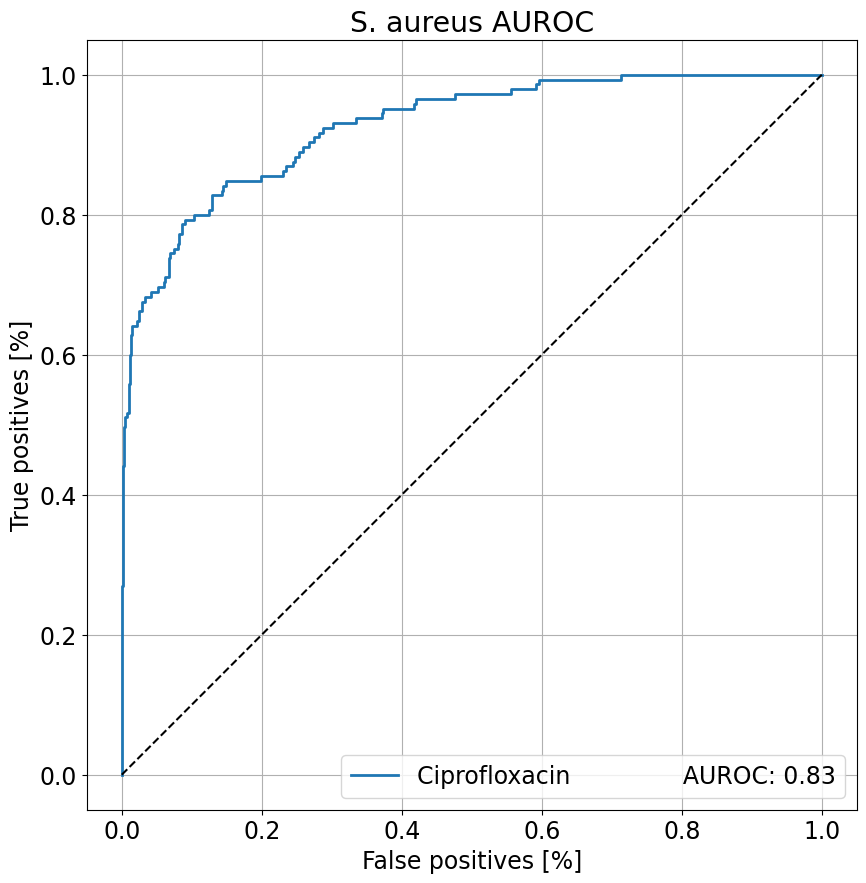

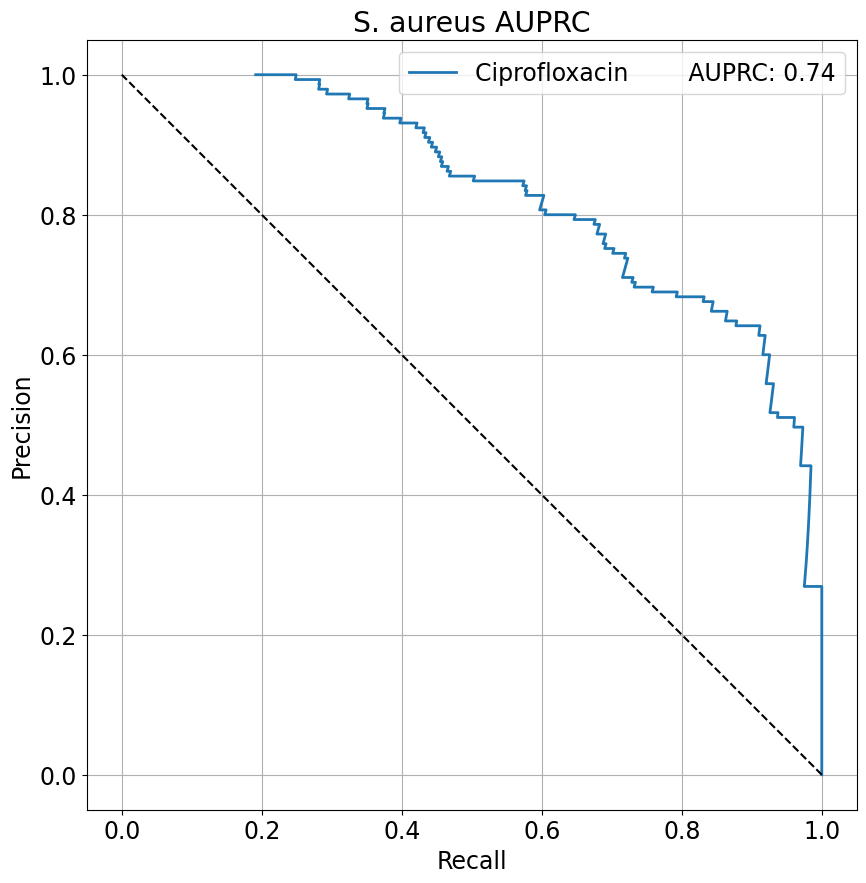

In [106]:
plt.rcParams['figure.figsize'] = (12, 10)
plt.rcParams.update({'font.size': 17})
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

def plot_roc(name, labels, predictions, **kwargs):
  fp, tp, _ = sklearn.metrics.roc_curve(labels, predictions)

  plt.plot(fp, tp, label=name, linewidth=2, **kwargs)
  plt.plot([0, 1], [0, 1], 'k--')
  plt.title('E. coli CNN')
  plt.xlabel('False positives [%]')
  plt.ylabel('True positives [%]')
  plt.title('S. aureus AUROC')

  plt.grid(True)
  ax = plt.gca()
  ax.set_aspect('equal')
plot_roc("Ciprofloxacin               AUROC: %0.2f" % baseline_results[8], y_test, test_predictions_baseline, color=colors[0])

plt.legend(loc='lower right')
plt.savefig('s_aureus_auroc.png', bbox_inches='tight')
plt.show()

def plot_prc(name, labels, predictions, **kwargs):
    precision, recall, _ = sklearn.metrics.precision_recall_curve(labels, predictions)

    plt.plot(precision, recall, label=name, linewidth=2, **kwargs)
    plt.title('S. aureus AUPRC')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.plot([1, 0], [0, 1], 'k--')
    plt.grid(True)
    ax = plt.gca()
    ax.set_aspect('equal')

plot_prc("Ciprofloxacin        AUPRC: %0.2f" % baseline_results[9], y_test, test_predictions_baseline, color=colors[0])

plt.legend(loc='upper right')
plt.savefig('s_aureus_auprc.png', bbox_inches='tight')
plt.show()